# Example Python guide to get started.

Getting started example. \
Updated - 5/9/2023 \
Author - Shravan Aras (shravanaras@email.arizona.edu)

# Introduction

Import the athena helper library to access the database via sensorfabric. Your AWS credentials will already be configured for this app.

In [23]:
from sensorfabric.athena import athena
import pandas as pd

Connect to the database and workgroup provided to you for this study. Replace `my-database` with the database name, and `my-workgroup` with the name of the workgroup given.

In [24]:
db = athena(database='my-database', workgroup='my-workgroup')

You can see a list of all tables by running the below query. `execQuery` accepts an SQL query and returns a pandas dataframe after execution. 

In [25]:
results = db.execQuery('SHOW TABLES')
display(results)

,fitbitactivitylogs
0,fitbitdailydata
1,fitbitdevices
2,fitbitrestingheartrates
3,fitbitsleeplogdetails
4,fitbitsleeplogs


# Caching

Sensorfabric supports local caching. Please note this cache will be destroyed after the container / app / analysis job has been closed.
To enable caching you can set the parameter `offlineCache=True`

In [26]:
db_with_caching = athena(database='my-database', workgroup='my-workgroup', offlineCache=True)

You can chose to enable caching for individual queries by setting `cached=True`

### Comparing between cached an uncached

In [27]:
%%time
results = db_with_caching.execQuery('SELECT * FROM fitbitdailydata')
print(results.shape)

(3817, 65)
CPU times: user 1.38 s, sys: 76.2 ms, total: 1.46 s
Wall time: 3.94 s


In [28]:
%%time
results = db_with_caching.execQuery('SELECT * FROM fitbitdailydata')
print(results.shape)

(3817, 65)
CPU times: user 1.18 s, sys: 54.7 ms, total: 1.24 s
Wall time: 3.71 s


We can see for the exact same query without caching, it takes 3-4 seconds each time it runs.
Using cached results we get instant response as shown below in 153 ms.

In [29]:
%%time
results = db_with_caching.execQuery('SELECT * FROM fitbitdailydata', cached=True)
print(results.shape)

(3817, 65)
CPU times: user 41.2 ms, sys: 4.14 ms, total: 45.3 ms
Wall time: 140 ms


# Example - Studying Fitbit resting HR values.

We will install plotly library for plotting. You can use this method to install any additional libraries you need. \
**Important** \
You will need to open the extensions tab on the left and install jupyterlab-plotly extension. Once enabled it will ask you if you want to rebuilt extensions and restart. Say Yes. \
The build might take several minutes depending on your compute. We plan to have this included in the prebuilt image by the end of summer 2023.
Graphs may not correctly display without that.

In [30]:
%pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [31]:
import plotly.express as px

In [32]:
# Let us see how the resting HR table looks like.
db = db_with_caching # we want to enable caching for queries if needed.

results = db.execQuery('SHOW COLUMNS FROM fitbitrestingheartrates')
display(results)

,participantidentifier
0,date
1,restingheartrate
2,_provenance


Let's look at a quick summary of resting HR for participants.

In [33]:
query = """
    SELECT participantidentifier, 
        AVG(restingheartrate) avg_hr, 
        MIN(restingheartrate) min_hr,
        MAX(restingheartrate) max_hr
            FROM fitbitrestingheartrates
            GROUP BY participantidentifier
            ORDER BY avg_hr DESC
"""
results_summary = db.execQuery(query, cached=True)
# For this demo output we are hiding / dropping the participantidentifiers and instead replacing them with a sequence of numbers.
results_summary['participantidentifier'] = ['p{}'.format(n) for n in range(0, results_summary.shape[0])]
display(results_summary)

,participantidentifier,avg_hr,min_hr,max_hr
0,p0,83.825581,76.0,90.0
1,p1,83.034483,80.0,86.0
2,p2,74.898455,67.0,83.0
3,p3,74.283784,68.0,82.0
4,p4,70.885714,65.0,76.0
5,p5,69.027778,60.0,76.0
6,p6,68.724138,62.0,75.0
7,p7,67.500000,67.0,68.0
8,p8,64.136364,60.0,69.0
9,p9,64.090909,57.0,70.0


Let us see how the distribution of resting HR looks like.

In [34]:
results = db.execQuery('SELECT restingheartrate FROM fitbitrestingheartrates WHERE restingheartrate IS NOT NULL', cached=True)

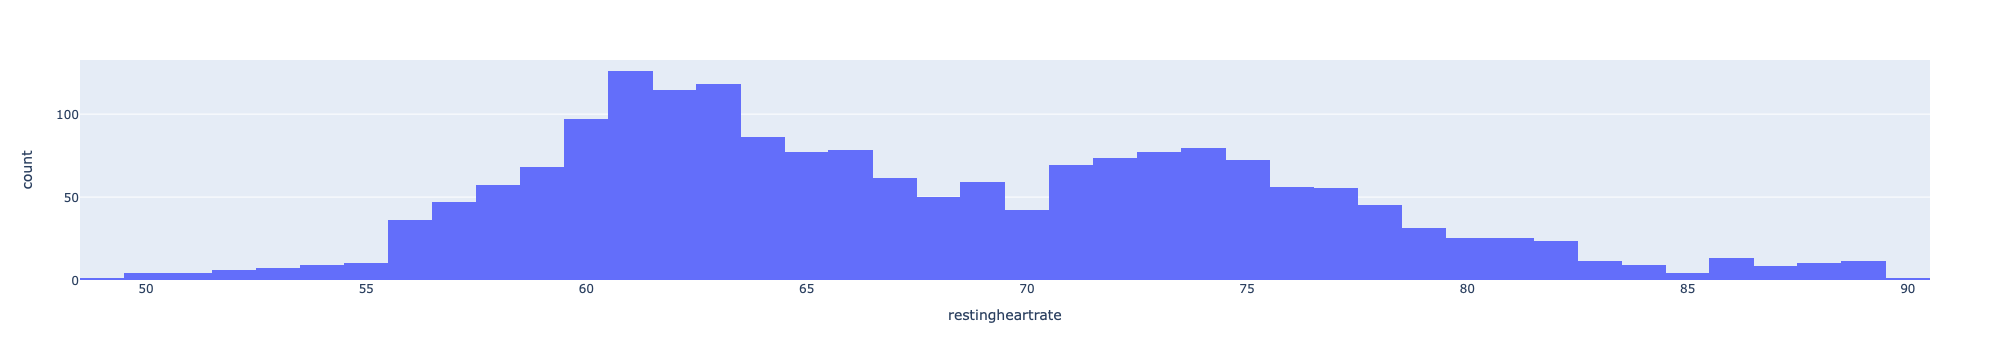

In [35]:
fig = px.histogram(results, x='restingheartrate')
fig.show()

You can also save this file to be accessed from inside R as a frame to do your analysis.

In [36]:
results_summary.to_csv('restinghr_summary.csv')